# Knowledge graph using `semantikon`

## Background

If you are somewhat familiar with ontology, you must have encountered the problem: There is an ontology for your field available, along with some simulation tools. You would like to combine them to give ontological information to your data, but it is just too much of an effort to understand the structure of the ontology and integrate it into your workflow. `semantikon` gives you a simple tool to easily annotate your workflow nodes with ontological information.

## Data aquisition

The following example shows a simple workflow containing two steps: 1. calculate speed from distance and time; 2. calculate corresponding kinetic energy. For this and following examples we use a mock up ontology `EX`, which should be replaced by the ontology of your choice.

In [1]:
from rdflib import Namespace

In [2]:
EX = Namespace("http://www.example.org/")

In [3]:
from semantikon import get_knowledge_graph, query_io_completer, u, visualize_recipe
from semantikon.workflow import workflow


def get_speed(
    distance: u(float, uri=EX.distance, units="meter"),
    time: u(float, uri=EX.time, units="second")
) -> u(float, uri=EX.velocity, units="meter/second"):
    speed = distance / time
    return speed


def get_kinetic_energy(
    mass: u(float, uri=EX.mass, units="kilogram"),
    velocity: u(float, uri=EX.velocity, units="meter/second")
) -> u(float, uri=EX.kineticEnergy, units="joule"):
    return 0.5 * mass * velocity**2

Here we defined units and URI, but except for the data type, there is nothing required. The function `u` turns the content into `typing.Annotated`. If you prefer, instead of `u(float, uri=EX.distance, units="meter")`, you can also write: `typing.Annotated[float, {"uri": EX.distance, "units": "meter"}]`.

Based on the two functions/nodes `get_speed` and `get_kinetic_energy`, we create the following workflow.

In [4]:
@workflow
def my_workflow(distance, time, mass):
    speed = get_speed(distance, time)
    kinetic_energy = get_kinetic_energy(mass, speed)
    return kinetic_energy

Note: `semantikon` also offers some basic workflow managing tools, but ideally you should use the workflow manager of your choice, such as `pyiron_workflow`. There is an ongoing development to represent workflows in a unified format, which would allow `semantikon` to directly obtain ontological information from the workflow manager. It can either directly support the `semantikon` format:

In [5]:
workflow_dict = my_workflow.serialize_workflow()

print(workflow_dict)

{'inputs': {'distance': {}, 'time': {}, 'mass': {}}, 'outputs': {'kinetic_energy': {}}, 'nodes': {'get_kinetic_energy_0': {'function': <function get_kinetic_energy at 0x13c200360>, 'type': 'Function', 'inputs': {'mass': {'uri': rdflib.term.URIRef('http://www.example.org/mass'), 'units': 'kilogram', 'dtype': <class 'float'>}, 'velocity': {'uri': rdflib.term.URIRef('http://www.example.org/velocity'), 'units': 'meter/second', 'dtype': <class 'float'>}}, 'outputs': {'output': {'uri': rdflib.term.URIRef('http://www.example.org/kineticEnergy'), 'units': 'joule', 'dtype': <class 'float'>}}}, 'get_speed_0': {'function': <function get_speed at 0x107f32de0>, 'type': 'Function', 'inputs': {'distance': {'uri': rdflib.term.URIRef('http://www.example.org/distance'), 'units': 'meter', 'dtype': <class 'float'>}, 'time': {'uri': rdflib.term.URIRef('http://www.example.org/time'), 'units': 'second', 'dtype': <class 'float'>}}, 'outputs': {'speed': {'uri': rdflib.term.URIRef('http://www.example.org/veloci

Or the flowrep format:

In [6]:
from flowrep import workflow as fwf

print(fwf.get_workflow_dict(my_workflow))

{'nodes': {'get_kinetic_energy_0': {'function': <function get_kinetic_energy at 0x13c200360>, 'type': 'Function'}, 'get_speed_0': {'function': <function get_speed at 0x107f32de0>, 'type': 'Function'}}, 'edges': [('inputs.distance', 'get_speed_0.inputs.distance'), ('inputs.time', 'get_speed_0.inputs.time'), ('inputs.mass', 'get_kinetic_energy_0.inputs.mass'), ('get_speed_0.outputs.output', 'get_kinetic_energy_0.inputs.velocity'), ('get_kinetic_energy_0.outputs.output', 'outputs.kinetic_energy')], 'label': 'my_workflow', 'type': 'Workflow'}


In [7]:
# Extract knowledge graph. For demo purposes a fixed prefix is set, but semantikon automatically creates a hash for this by default
graph = get_knowledge_graph(workflow_dict, prefix="demo")

In [8]:
print(graph.serialize())

@prefix bfo: <http://purl.obolibrary.org/obo/BFO_> .
@prefix iao: <http://purl.obolibrary.org/obo/IAO_> .
@prefix obi: <http://purl.obolibrary.org/obo/OBI_> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pmdco: <https://w3id.org/pmd/co/PMD_> .
@prefix qudt: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ro: <http://purl.obolibrary.org/obo/RO_> .
@prefix sns: <http://pyiron.org/ontology/> .
@prefix unit: <http://qudt.org/vocab/unit/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

sns:__main__-get_kinetic_energy-not_defined_input_mass a pmdco:0000014 ;
    rdfs:label "mass" ;
    iao:0000136 <http://www.example.org/mass> ;
    pmdco:0001857 0 .

sns:__main__-get_kinetic_energy-not_defined_input_velocity a pmdco:0000014 ;
    rdfs:label "velocity" ;
    iao:0000136 <http://www.example.org/velocity> ;
    pmdco:0001857 1 .

sns:__main__-get_kinetic_energy-not_defined_output_output a pmdco:0000015 ;
    rdfs:label "output" 

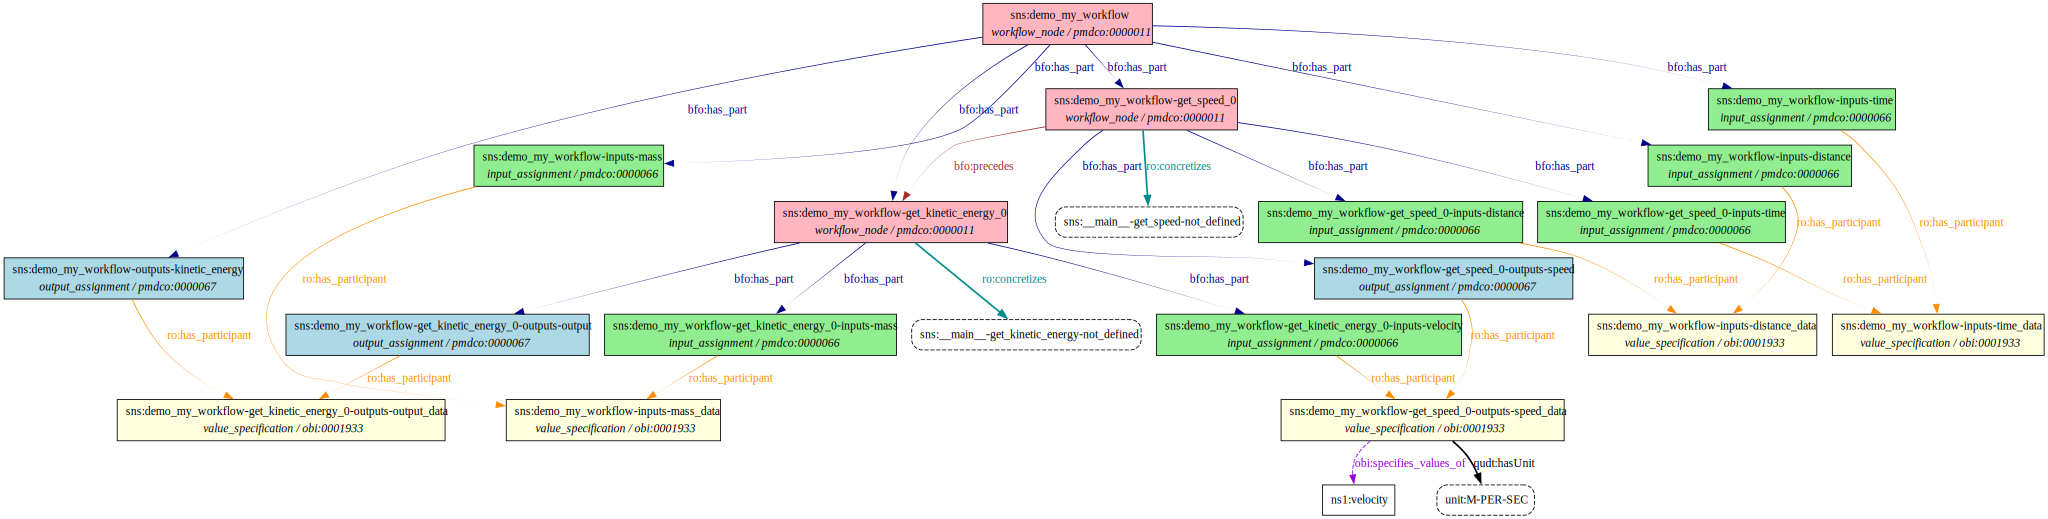

In [9]:
visualize_recipe(graph)

In [10]:
executed_workflow_dict = my_workflow.run(distance=1, time=2, mass=3)
executed_graph = get_knowledge_graph(executed_workflow_dict, prefix="demo")

Now you can query the data with `query_io_completer`, which allows you to look for terms via tab-completion, and then `SparqlWriter`, which writes the SPARQL query for you.

In [11]:
comp = query_io_completer(executed_graph)
G = comp.demo_my_workflow.inputs.distance & comp.demo_my_workflow.outputs.kinetic_energy
assert G.query() == [(1, 0.375)]

In order to make it a bit more interesting, we can also vary the input a little bit:

In [12]:
for distance in [2, 3, 4]:
    executed_graph += get_knowledge_graph(my_workflow.run(distance=distance, time=2, mass=3), prefix="demo")

In [13]:
G = comp.demo_my_workflow.inputs.distance & comp.demo_my_workflow.outputs.kinetic_energy
assert G.query() == [(1, 0.375), (2, 1.5), (3, 3.375), (4, 6.0)]

### Retrieving previous results from the knowledge graph

When you run a workflow with the same input values, you would like to make sure that the data can be automatically retrieved from the knowledge graph. This can be done with semantikon using the `request_values`-method

In [14]:
# mock up database knowledge graph. Again with prefix for the demo purpose
database_graph = get_knowledge_graph(my_workflow.run(distance=1.0, time=2.0, mass=3.0), prefix="demo")

In [15]:
# Create a new workflow
wf_before_execution = my_workflow.serialize_workflow()
assert wf_before_execution["outputs"] == {"kinetic_energy": {}}

Quite obviously there is no value in the output. Now we assign values (it looks somewhat clumsy to do it manually here, that's because semantikon is not a workflow manager, so in principle this should be done outside of semantikon): 

In [16]:
wf_before_execution["inputs"]["distance"]["value"] = 1.0
wf_before_execution["inputs"]["time"]["value"] = 2.0
wf_before_execution["inputs"]["mass"]["value"] = 3.0

In [17]:
from semantikon import request_values

In [18]:
assert request_values(wf_before_execution, database_graph)["outputs"] == {"kinetic_energy": {"value": 0.375}}

Believe me or not, the output was retrieved without running the simulation

## Validate connections

One of the reasons to semantically describe workflows is to validate input and output connections. `semantikon` offers the following validation schemes:

- Type checking
- OWL restrictions
- SHACL constraints

We show the examples below how these checks can be performed.

Note: `semantikon` currently does not support python type checking. This is because it fully focuses on the semantic types defined in the knowledge graph. This might be included at some point in the future though.

### Type checking

In this example, the node `eat` accepts anything that's meal, so we prepare pizza, which is a subclass of meal and insert it into `eat`.

In [19]:
from semantikon.ontology import validate_values


In [20]:
class Meal:
    pass


def prepare_pizza() -> u(Meal, uri=EX.Pizza):
    return Meal()


def eat(meal: u(Meal, uri=EX.Meal)) -> str:
    return "I am full after eating "


@workflow
def eat_pizza():
    pizza = prepare_pizza()
    comment = eat(pizza)
    return comment


wf_dict = eat_pizza.serialize_workflow()
graph = get_knowledge_graph(wf_dict)
verdict, _, report = validate_values(graph)
assert not verdict
print(report)

Validation Report
Conforms: False
Results (1):
Constraint Violation in ClassConstraintComponent (http://www.w3.org/ns/shacl#ClassConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type sh:PropertyShape ; sh:class <http://www.example.org/Meal> ; sh:path <http://purl.obolibrary.org/obo/OBI_0001927> ]
	Focus Node: [ <http://purl.obolibrary.org/obo/IAO_0000235> [ rdf:type <http://purl.obolibrary.org/obo/IAO_0020000>, rdfs:Resource ; rdf:value Literal("8a3209524b656c25233a246653c9da5a2ab5f5df4ad1711f08023a6243297471@output") ] ; <http://purl.obolibrary.org/obo/OBI_0001927> [ rdf:type <http://www.example.org/Pizza>, rdfs:Resource ] ; rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:allValuesFrom <http://www.example.org/Meal> ; owl:onProperty <http://purl.obolibrary.org/obo/OBI_0001927> ; rdf:type owl:Restriction, rdfs:Resource ], [ owl:onProperty <http://purl.obolibrary.org/obo/IAO_0000235> ; owl:someValuesFrom <http://purl.obolibrary.org/obo/IAO_0020000> ; rdf:ty

At this point, since the ontology is not defined, `validate_values` thinks `EX.Pizza` is not compatible with `EX.Meal`, so we extend the ontology to indicate that pizza is also a meal:

In [21]:
from rdflib import RDFS

In [22]:
graph.add((EX.Pizza, RDFS.subClassOf, EX.Meal))
verdict, _, report = validate_values(graph)
assert verdict
print(report)

Validation Report
Conforms: True



### Units checking

Basically the same check as for the URI can be done for the units. Here we show you a nonsensical connection between length and duration:

In [23]:
def meter_to_angstrom(length: u(float, units="meter")) -> u(float, units="angstrom"):
    return length * 1e10

def seconds_to_nanoseconds(duration: u(float, units="seconds")) -> u(float, units="nanoseconds"):
    return duration * 1e9

@workflow
def meter_to_nanoseconds(length):
    length = meter_to_angstrom(length=length)
    duration = seconds_to_nanoseconds(duration=length)
    return duration

In [24]:
wf_dict = meter_to_nanoseconds.serialize_workflow()
graph = get_knowledge_graph(wf_dict)
verdict, _, report = validate_values(graph)
assert not verdict
print(report)

Validation Report
Conforms: False
Results (1):
Constraint Violation in HasValueConstraintComponent (http://www.w3.org/ns/shacl#HasValueConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type sh:PropertyShape ; sh:hasValue unit:SEC ; sh:path qudt:hasUnit ]
	Focus Node: [ qudt:hasUnit unit:ANGSTROM ; rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:hasValue unit:SEC ; owl:onProperty qudt:hasUnit ; rdf:type owl:Restriction, rdfs:Resource ], rdfs:Resource, sns:Wec536fd5_meter_to_nanoseconds-meter_to_angstrom_0-outputs-output_data ]
	Result Path: qudt:hasUnit
	Message: Node [ qudt:hasUnit unit:ANGSTROM ; rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:hasValue unit:SEC ; owl:onProperty qudt:hasUnit ; rdf:type owl:Restriction, rdfs:Resource ], rdfs:Resource, sns:Wec536fd5_meter_to_nanoseconds-meter_to_angstrom_0-outputs-output_data ]->qudt:hasUnit does not contain a value in the set: ['unit:SEC']



As you could easily imagine, `validate_values` complains about the connection of `angstrom` and `seconds`. By the way, even if the units are the same dimension (e.g. angstrom and meter), the current implementation would complain, in which case you have to make sure yourself to make a conversion beforehand.

Now you might wonder what happens if the units are not given at all. Here's basically the same example as above:

In [25]:
def meter_to_angstrom_without_units(length):
    return length * 1e10

@workflow
def meter_to_nanoseconds_without_units(length):
    length = meter_to_angstrom_without_units(length=length)
    duration = seconds_to_nanoseconds(duration=length)
    return duration

In [26]:
wf_dict = meter_to_nanoseconds_without_units.serialize_workflow()
graph = get_knowledge_graph(wf_dict)
verdict, _, report = validate_values(graph)
assert not verdict
print(report)

Validation Report
Conforms: False
Results (1):
Constraint Violation in HasValueConstraintComponent (http://www.w3.org/ns/shacl#HasValueConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type sh:PropertyShape ; sh:hasValue unit:SEC ; sh:path qudt:hasUnit ]
	Focus Node: [ rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:hasValue unit:SEC ; owl:onProperty qudt:hasUnit ; rdf:type owl:Restriction, rdfs:Resource ], rdfs:Resource, sns:W18a3f6e9_meter_to_nanoseconds_without_units-meter_to_angstrom_without_units_0-outputs-output_data ]
	Result Path: qudt:hasUnit
	Message: Node [ rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:hasValue unit:SEC ; owl:onProperty qudt:hasUnit ; rdf:type owl:Restriction, rdfs:Resource ], rdfs:Resource, sns:W18a3f6e9_meter_to_nanoseconds_without_units-meter_to_angstrom_without_units_0-outputs-output_data ]->qudt:hasUnit does not contain a value in the set: ['unit:SEC']



As you can see, if the input expects certain units, `validate_values` in principle complains. If you don't want this, you can turn off `strict_typing` to ignore all cases where the units and URIs are not defined.

In [27]:
wf_dict = meter_to_nanoseconds_without_units.serialize_workflow()
graph = get_knowledge_graph(wf_dict)
verdict, _, report = validate_values(graph, strict_typing=False)
assert verdict
print(report)

Validation Report
Conforms: True



### Define restrictions

Let's take the following example: You would like to represent the supply chain of clothes. Before they are sold, they have to be dyed and washed. Typically, these nodes (`wash` and `dye`) are performed by different players, so that their processes do not require the clothes to have gone through certain processes beforehand. In other words, you can dye clothes whether they have been washed before or not, which also applies to washing. However, you would like to apply the restriction on the input clothes of `sell` to have gone through `wash` and `dye` beforehand. That's a very difficult condition to represent using conventional python classes, but `semantikon` can handle it.

Here's what's expected in short (it does not render nicely on GitHub -> load it in your jupyter environment):

`def dye`:
```mermaid
flowchart LR
clothes(clothes) --> dye[[dye]] --> dyed(clothes + dyed)
```

`def wash`:
```mermaid
flowchart LR
clothes(clothes) --> wash[[wash]] --> washed(clothes + washed)
```

`def sell`:
```mermaid
flowchart LR
clothes(clothes + dyed + washed) --> sell[[sell]]
```

In [28]:
from rdflib import OWL, Namespace

from semantikon import SemantikonURI

EX = Namespace("http://www.example.org/")

uri_color = SemantikonURI(EX.Color)
uri_cleaned = SemantikonURI(EX.Cleaned)

class Clothes:
    pass

def wash(clothes: Clothes) -> u(
    Clothes,
    triples=(EX.hasProperty, uri_cleaned),
    derived_from="inputs.clothes"
):
    ...
    return clothes

def dye(clothes: Clothes, color="blue") -> u(
    Clothes,
    triples=(EX.hasProperty, uri_color),
    derived_from="inputs.clothes",
):
    ...
    return clothes

def sell(
    clothes: u(
        Clothes, restrictions=(
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.Cleaned)),
            ((OWL.onProperty, EX.hasProperty), (OWL.someValuesFrom, EX.Color))
        )
    )
) -> int:
    ...
    return 10

`derived_from` is a `semantikon` argument based on `bfo:derives_from` (or `prov:wasDerivedFrom`) to indicate that the output inherits properties (not ontological properties) from the inputs. If this predicate is not applied, `semantikon` does not create a direct connection between the input and the output.

The notation `triples=(EX.hasProperty, uri_cleaned))` is the short form for `triples=("outputs.clothes", EX.hasProperty, uri_cleaned)`. In this case `outputs.clothes` is automatically replaced by the ontological node that is created for the output. The following notations are equivalent:

- `triples=(EX.hasProperty, uri_cleaned)` (subject automatically replaced by the argument)
- `triples=(None, EX.hasProperty, uri_cleaned)` (`None` will be replaced by the argument)
- `triples=("self", EX.hasProperty, uri_cleaned)` (`"self"` will be replaced by the argument)
- `triples=("outputs.clothes", EX.hasProperty, uri_cleaned)`

The same applies to the [OWL restrictions](https://www.cs.vu.nl/~guus/public/owl-restrictions/), which are defined by `restrictions=`.

In case you have multiple return values, you can annotate them separately via `tuple[u(...), u(...), ...]`. `semantikon` treats them as separate knowledge graph nodes.

In this example we had nice return variable names. However, if the name is not represented by a python variable, such as `a + b`, it is replaced by `output` or `output_i` in case there are multiple return variables. Otherwise you can also specify the label via the `label` argument inside `u`.

`SemantikonURI` gives you an object, which acts as a class in the T-box (i.e. it simply returns the input class), and as an instance in the A-box. Quite obviously you can define multiple `SemantikonURI` for the same class, which would create distinct instances.

First, we create a notebook with the correct nodes:

In [29]:
@workflow
def my_correct_workflow(clothes: Clothes) -> int:
    dyed_clothes = dye(clothes)
    washed_clothes = wash(dyed_clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(my_correct_workflow.serialize_workflow())
verdict, v_graph, report = validate_values(graph)
assert verdict

In [30]:
print(report)

Validation Report
Conforms: True



As you can see `validate_values` validates the graph, because `dye` attaches the property `Color`, and `wash` attaches the property `Clean` to the argument `clothes`, where the properties are passed down via `derived_from` (without which only `Clean` would reach the input of `sell`, because that's the only thing that the output of `wash` knows). Now, we create a workflow without `dye`:

In [31]:
@workflow
def my_wrong_workflow(clothes: Clothes) -> int:
    washed_clothes = wash(clothes)
    money = sell(washed_clothes)
    return money

graph = get_knowledge_graph(my_wrong_workflow.serialize_workflow())
verdict, v_graph, report = validate_values(graph)
assert not verdict
print(report)

Validation Report
Conforms: False
Results (1):
Constraint Violation in QualifiedValueShapeConstraintComponent (http://www.w3.org/ns/shacl#QualifiedMinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type sh:PropertyShape ; sh:path <http://www.example.org/hasProperty> ; sh:qualifiedMinCount Literal("1", datatype=xsd:integer) ; sh:qualifiedValueShape [ sh:class <http://www.example.org/Color> ] ]
	Focus Node: [ <http://purl.obolibrary.org/obo/RO_0001000> [ rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, rdfs:Resource, sns:W79e6a08c_my_wrong_workflow-inputs-clothes_data ] ; <http://www.example.org/hasProperty> [ rdf:type <http://www.example.org/Cleaned>, rdfs:Resource ] ; rdf:type <http://purl.obolibrary.org/obo/OBI_0001933>, [ owl:onProperty <http://purl.obolibrary.org/obo/RO_0001000> ; owl:someValuesFrom sns:W79e6a08c_my_wrong_workflow-inputs-clothes_data ; rdf:type owl:Restriction, rdfs:Resource ], [ owl:onProperty <http://www.example.org/hasProperty> ; owl

This time, `validate_values` reports a missing connection

## Use dataclass to bundle parameters

There are two extra functionalities of `semantikon` that allows you to use `dataclasses.dataclass`. The one is `semantikon.semantikon_dataclass`, which behaves just like `dataclasses.dataclass`, with the exception that the class attributes carry the type hints, i.e. in the following example, `SpeedData.distance` (note: not instantiated) gives the type hint `u(float, uri=EX.distance, units="meter")`. With this, you can define a class in one place so that you don't have to define the type hint every time

In [32]:
from semantikon import semantikon_dataclass


@semantikon_dataclass
class SpeedData:
    distance: u(float, uri=EX.distance, units="meter")
    time: u(float, uri=EX.time, units="second")
    velocity: u(float, uri=EX.velocity, units="meter/second")


def get_speed_with_semantikon_dataclass(
    distance: SpeedData.distance, time: SpeedData.time
) -> SpeedData.velocity:
    speed = distance / time
    return speed

In [33]:
@workflow
def workflow_with_semantikon_dc(distance, time, mass):
    speed = get_speed_with_semantikon_dataclass(distance, time)
    kinetic_energy = get_kinetic_energy(mass, speed)
    return kinetic_energy

In [34]:
wf_dict_with_semantikon_dc = workflow_with_semantikon_dc.run(1, 2, 3)
graph_with_semantikon_dc = get_knowledge_graph(wf_dict_with_semantikon_dc, prefix="demo")

comp = query_io_completer(graph_with_semantikon_dc)
G = comp.demo_workflow_with_semantikon_dc.inputs.distance & comp.demo_workflow_with_semantikon_dc.outputs.kinetic_energy
assert G.query() == [(1, 0.375)]

### Use `dataclass` instead of individual parameters

Another possibility to leverage `dataclasses.dataclass` is to directly use the dataclass object for the input/output of a workflow. In this case, the attributes are automatically stored as `rdfs:subClassOf`, when `extract_dataclass` is set to `True`.

In [35]:
from dataclasses import dataclass


@dataclass
class NewSpeedData:
    distance: u(float, uri=EX.distance, units="meter")
    time: u(float, uri=EX.time, units="second")


def get_speed_with_dataclass(speed_data: NewSpeedData) -> SpeedData.velocity:
    speed = speed_data.distance / speed_data.time
    return speed

In [36]:
@workflow
def workflow_with_dataclass(speed_data, mass):
    speed = get_speed_with_dataclass(speed_data)
    kinetic_energy = get_kinetic_energy(mass, speed)
    return kinetic_energy

In [37]:
speed_data = NewSpeedData(distance=1.0, time=2.0)

In [38]:
wf_dict_with_dataclass = workflow_with_dataclass.run(speed_data=speed_data, mass=3)
graph_with_dataclass = get_knowledge_graph(wf_dict_with_dataclass, extract_dataclasses=True, prefix="demo")

In [39]:
comp = query_io_completer(graph_with_dataclass)

Unfortunately, there is no way to straightforwardly look up field arguments in the knowledge graph, so we do a little hacking here to refer to the node directly.

In [40]:
from rdflib import URIRef

G = URIRef("http://pyiron.org/ontology/demo_workflow_with_dataclass-inputs-speed_data_distance_data") & comp.demo_workflow_with_dataclass.outputs.kinetic_energy

In [41]:
assert G.query() == [(1.0, 0.375)]